In [1]:
import sys
import os
import itertools

import numpy as np
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


sys.path.append("../../ndsvae/")
import ndsvae as ndsv

sys.path.append("..")
import plot
import plotutils as pu
import util
import dsa


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Matplotlib config

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load data

In [3]:
! ls ../run/hcp/hcp100_linw_dicer/

dataset.npz  img  modelAB  modelAN  surrogates.npz


In [4]:
conn = "linw"
preproc = "dicer"
modelname = "AB"
config = "ns_3_mreg_3_msub_0_nf_32"
isub = 5

In [5]:
ds = ndsv.Dataset.from_file(f"../run/hcp/hcp100_{conn}_{preproc}/dataset.npz")

run = util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname, config, [0,1], "hcp")
direc = f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}"
sims = ndsv.GeneratedData.from_file(os.path.join(direc, f"simulations/simulations_{isub:03d}.npz"))    
params = util.load_params(os.path.join(direc, "parameters"), range(0, 100))
model = util.get_model(modelname, config, ds)
model.load_weights(os.path.join(direc, "fit/model"))

nt = ds.y.shape[-1]

2022-09-06 17:08:59.125950: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-06 17:08:59.150369: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3399905000 Hz
2022-09-06 17:08:59.150770: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561e7049b5f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-06 17:08:59.150784: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-09-06 17:08:59.150857: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Separate panels

In [6]:
colors = ['tab:blue', 'tab:green']

def plot_obs_all(ax, t, y, iregs, title=None):
    plt.sca(ax)
    if title:
        plt.title(title)
    plt.imshow(y, aspect='auto', interpolation='none', vmin=-2.5, vmax=2.5, cmap='magma')
    plt.yticks([])
    plt.xticks([])
    plt.ylabel("Regions")
    
    for i, ireg in enumerate(iregs):
        plt.scatter(-1, ireg, color=colors[i], marker=5, clip_on=False, s=20, lw=0)
    plt.xlim(0, y.shape[1])
    
def plot_fc(ax, cax, y):
    plt.sca(ax)
    plt.title("Functional conn.")
    fc = np.corrcoef(y)
    im = plt.imshow(fc, vmin=-1, vmax=1, cmap='bwr', interpolation='none')
    plt.xticks([])
    plt.yticks([])    
    plt.xlabel("Regions")
    plt.ylabel("Regions")
    
    if cax is not None:
        plt.colorbar(im, cax=cax, orientation='vertical')
        cax.tick_params(axis=u'y', which=u'both',length=0)
        
        
def plot_obs_lines(ax, t, ys, labels, offset=4, us=None):
    n = len(ys)
    
    plt.sca(ax)
    for i, y in enumerate(ys):
        plt.plot(t, y - offset*i, color=colors[i], lw=0.3)
    
    if us is not None:
        plt.plot(t, us + 1.5*offset, color='k', lw=0.3)

    plt.xlim(t[0], t[-1])    
    plt.xlabel("Time")
    plt.xticks([])

    plt.ylim(-n*offset, 2.5*offset)
    if us is None:
        plt.yticks(-offset*np.r_[0:n], labels)
    else:
        plt.yticks(list(-offset*np.r_[0:n]) + [1.5*offset], list(labels) + ["Input"])
                
    for ytick, color in zip(ax.get_yticklabels()[:n], colors[:n]):
        ytick.set_color(color)
    pu.bottomleft_spines(ax)

        
def plot_observations(gs, t, y, examples, us=None):
    # left, right, bottom, top = pos
    
    # gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[2,1], width_ratios=[2,1.4],
    #                       left=left, right=right, bottom=bottom, top=top, hspace=0.6, wspace=0.3)
    ax1 = plt.subplot(gs[0,0])
    plot_obs_all(ax1, t, y, examples, title="Time series")

    labels = "ABCDEFGHI"[:len(examples)]    
    ax2 = plt.subplot(gs[1,0])
    plot_obs_lines(ax2, t, y[examples], labels=labels, offset=4, us=us)
    # plt.xlim(0,150)
    
    vpos = 7 if us is None else 12
    plt.plot([60, 120], [vpos,vpos], lw=2, color='k', clip_on=False)
    plt.text(90, vpos+1, "60 s", ha='center', va='bottom', clip_on=False, fontsize=8)

    ax3 = plt.subplot(gs[0,1])
    box = ax3.get_position()
    fig = ax3.figure
    cax3 = fig.add_axes([box.x0+box.width+0.005,box.y0+0.2*box.height,0.02,0.6*box.height])
    plot_fc(ax3, cax3, y)        

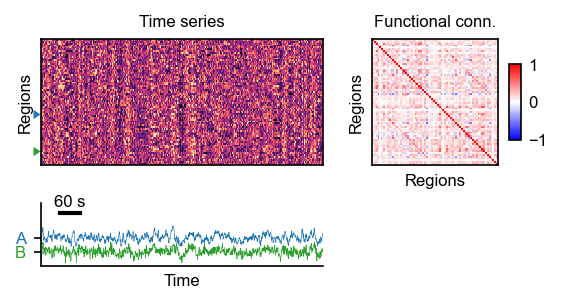

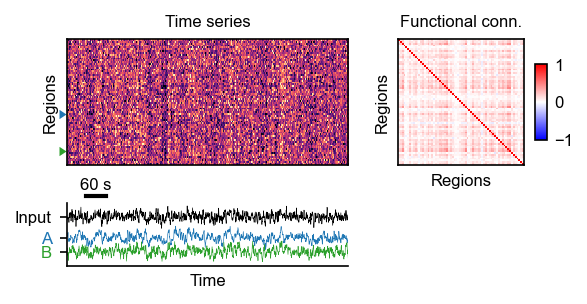

In [7]:
isample = 3
iregs = [40, 60]

plt.figure(figsize=(4,2), dpi=150)
gs = gridspec.GridSpec(2, 2, width_ratios=(2,1), height_ratios=(2,1), hspace=0.4)
plot_observations(gs, ds.t, ds.y[isub,:,0,:], iregs)

plt.figure(figsize=(4,2), dpi=150)
gs = gridspec.GridSpec(2, 2, width_ratios=(2,1), height_ratios=(2,1), hspace=0.4)
plot_observations(gs, ds.t, sims.y[isample,0,:,0,-nt:], iregs, us=sims.us[isample,0,-nt:])



### State space

In [8]:
def phaseplot2d(ax, model, c1, c2, x, thetareg, thetasub, u=0., ushared=0., scale=6, color='k'):
    assert c1 != c2
    
    plt.sca(ax)
    fx = ndsv.models.evalf(model, x, thetareg=thetareg, thetasub=thetasub, u=u, ushared=ushared)
        
    if c1 < c2: u, v = fx[:,:,c1].T, fx[:,:,c2].T
    else:       u, v = fx[:,:,c1], fx[:,:,c2]
        
    # plt.quiver(x[c1], x[c2], u, v, scale=scale, color=color)
    plt.streamplot(x[c1], x[c2], u, v, density=0.5, linewidth=0.5, arrowsize=0.25, color=color)
    
    velocity = np.sqrt(u**2 + v**2)
    plt.imshow(velocity, cmap='plasma', extent=[x[c1][0], x[c1][-1], x[c2][0], x[c2][-1]], origin='lower',
               alpha=0.5, zorder=-1, vmin=0, vmax=3)


def plot_phaseplot(ax, model, x, treg, tsub, dims=(0,1), dimnames=(1,2), nquiver=10, color='k', label=None,
                   xlabels=True, ylabels=True):
    
    plt.sca(ax)
    rng = (-2., 2.)
    
    # Trajectories
    for i in range(x.shape[0]):
        plt.plot(x[i,dims[0]], x[i,dims[1]], color='yellow', alpha=1, lw=0.25, zorder=10)
        
    # Fixed points
    xfp, is_stable, _, _ = dsa.find_fixed_points_node(model, treg, tsub, u=0., us=0.)        
    plt.scatter(xfp[is_stable,dims[0]],  xfp[is_stable, dims[1]],  color='k', s=8, ec='k', lw=0.5, zorder=30)
    plt.scatter(xfp[~is_stable,dims[0]], xfp[~is_stable, dims[1]], color='w', s=8, ec='k', lw=0.5, zorder=30)
    
    
    xq = [0. for _ in range(model.ns)]
    xq[dims[0]] = np.linspace(rng[0], rng[1], nquiver)
    xq[dims[1]] = np.linspace(rng[0], rng[1], nquiver)
    phaseplot2d(ax, model, dims[0], dims[1], x=xq, thetareg=treg, thetasub=tsub,
                u=0., ushared=0., scale=20, color='k')
    plt.xlim(rng); plt.ylim(rng)
    
    plt.xticks([-2,0,2], None if xlabels else ["","",""])
    if xlabels: plt.xlabel(f"$x_{dimnames[0]}$", labelpad=0)
        
    plt.yticks([-2,0,2], None if ylabels else ["","",""])
    if ylabels: plt.ylabel(f"$x_{dimnames[1]}$", labelpad=0)
    
    if label:
        plt.text(0.04, 0.96, label, ha='left', va='top', transform=ax.transAxes, color=color, fontsize=8, 
                 bbox=dict(boxstyle='square', facecolor='white', alpha=0.85))
        
    
    for pos in ['bottom', 'top', 'right', 'left']:
        ax.spines[pos].set_color(color)
        ax.spines[pos].set_linewidth(1.5)
    ax.tick_params(axis='both', colors=color)
    ax.xaxis.label.set_color(color)
    ax.yaxis.label.set_color(color)

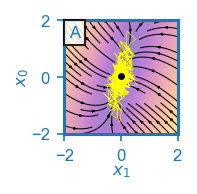

In [9]:
plt.figure(figsize=(1,1), dpi=150)
plot_phaseplot(plt.gca(), model, sims.x[isample:isample+1,0,iregs[0],:,-nt//2:-nt//4],
               treg=params.thetareg[isub,iregs[0],:,0], tsub=params.thetasub[isub,:,0],
               dims=(2,1), dimnames=(1,0), nquiver=50,
               color=colors[0],
               label="A", xlabels=True)

## Order of state dimensions

In [10]:
params.x.shape

(100, 68, 3, 1200, 2)

In [11]:
def calc_kl_timeseries(x, nsamples=10):
    nsub, nreg, ns, nt, _ = x.shape
        
    kl = np.full((nsub, nreg, ns, nt-1), np.nan)

    for (isub, ireg) in itertools.product(range(nsub), range(nreg)):
        xr = x[isub,ireg,:,1:,:]  # Note: we are removing the initial conditions
        ntm = nt - 1
        
        x1mu, x1std  = xr[:,:,0], xr[:,:,1]        
        xsamples = np.random.normal(x1mu[:,:,None], x1std[:,:,None], size=(ns, ntm, nsamples))        
        x2mu  = np.mean(np.reshape(xsamples, (ns, ntm*nsamples)), axis=1)
        x2std = np.std(np.reshape(xsamples, (ns, ntm*nsamples)), axis=1)

        for i in range(ns):
            kl[isub,ireg,i,:] = (np.log(x2std[i]/x1std[i]) 
                                 + (x1std[i]**2 + (x1mu[i] - x2mu[i])**2)/(2*x2std[i]**2) - 0.5)
    return np.mean(kl, axis=(0,1,3))

In [12]:
order = np.argsort(-calc_kl_timeseries(params.x))

In [13]:
order

array([1, 2, 0])

In [14]:
np.argsort(params.thetareg[5,:,0,0])

array([40, 25,  6, 43, 59, 57, 29, 23, 26,  9, 36, 61,  3, 51, 37, 19, 56,
       47, 45, 60, 52, 18, 53,  2, 17, 11, 50, 63, 27, 16, 54, 20, 22, 13,
       24, 28, 34, 62,  0, 39, 58,  8, 12,  7, 55, 64, 30, 21, 67, 41, 42,
       10, 46, 66,  1, 49,  5, 33, 48, 44, 32, 15, 14, 35, 31, 38,  4, 65])

## Figure

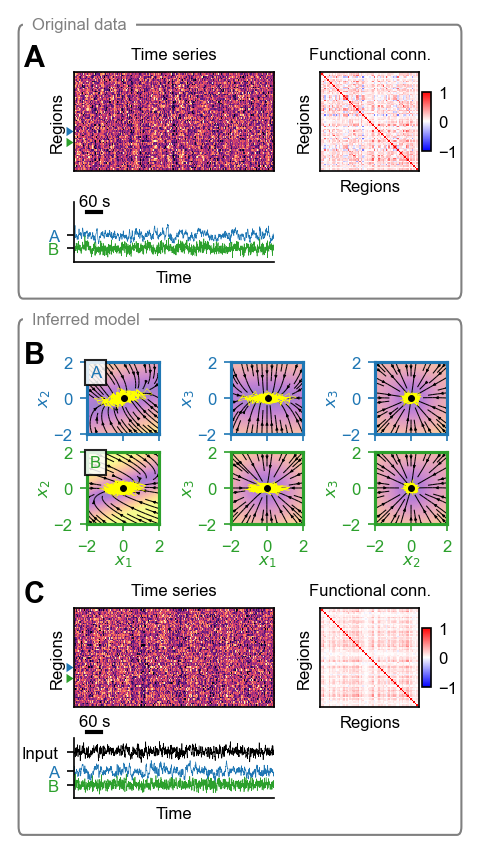

In [15]:
isub = 5
isample = 3
# iregs = [40, 60]
iregs = [40, 48]

fig = plt.figure(figsize=(3.0,5.5), dpi=150)


gs1 = fig.add_gridspec(nrows=2, ncols=2, left=0.13, right=0.90, bottom=0.7, top=0.93,
                       width_ratios=[2,1], height_ratios=[2,1.2], hspace=0.4, wspace=0.3)

gs2 = fig.add_gridspec(nrows=2, ncols=3, left=0.16, right=0.96, bottom=0.38, top=0.58, wspace=1.)

gs3 = fig.add_gridspec(nrows=2, ncols=2, left=0.13, right=0.90,  bottom=0.05, top=0.28,
                       width_ratios=[2,1], height_ratios=[2,1.2], hspace=0.4, wspace=0.3)


# Panels A
plot_observations(gs1, ds.t, ds.y[isub,:,0,:], iregs)

# Panels B
for i, (ireg, label) in enumerate(zip(iregs, ['A', 'B'])):
    for j, dims in enumerate([(0,1), (0,2), (1,2)]):
        truedims = order[list(dims)]        
        ax = plt.subplot(gs2[i,j])
        plot_phaseplot(ax, model, sims.x[isample:isample+1,0,iregs[i],:,-nt//2:-nt//4],
                       treg=params.thetareg[isub,iregs[i],:,0], tsub=params.thetasub[isub,:,0],
                       dims=truedims, dimnames=(dims[0]+1, dims[1]+1), nquiver=50,
                       color=colors[i],
                       label=(label if j == 0 else ""), xlabels=(i==1))


# Panels C
plot_observations(gs3, ds.t, sims.y[isample,0,:,0,-nt:], iregs, us=sims.us[isample,0,-nt:])


bg = pu.Background(visible=False)
bg.add_labels([0.02, 0.02, 0.02], [0.93, 0.57, 0.28], fontsize=14)

bg.box((0.018, 0.982, 0.665, 0.977), pad=0.01, title="Original data",  titlestyle={'fontsize':8})
bg.box((0.018, 0.982, 0.015, 0.62), pad=0.01, title="Inferred model", titlestyle={'fontsize':8})


plt.savefig(f"./img/Fig_HCP_Example.pdf")